In [1]:
import skimage
import skimage.io
import os, sys
import utils
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import mywarper

## Read in the 50 eigen-face

In [2]:
mdict = scipy.io.loadmat("PCA_Aligned_Eigen_Face.mat")
mean_image = mdict["mean_image"]
eigen_face = mdict["aligned_eigen_face"]

## Read in the 10 eigen-warpings

In [3]:
mdict = scipy.io.loadmat("PCA_Eigen_warping.mat")
mean_LM = mdict["mean_LM"]
eigen_warping = mdict["eigen_warping"][:10, :] # top 10 eigen warpings

## Define the test set and fetch the test set

In [4]:
image_folder = os.path.join(os.getcwd(), "images")
image_files = utils.files_under_folder_with_suffix(image_folder, suffix = '.jpg')
test_set_im = image_files[800:]

landmark_folder = os.path.join(os.getcwd(), "landmarks")
LM_files = utils.files_under_folder_with_suffix(landmark_folder, suffix = '.mat')
test_set_LM = LM_files[800:]

aligned_folder = os.path.join(os.getcwd(), "aligned_images")

In [12]:
_, X_test_LM = utils.LM_mean_LM_data(landmark_folder, test_set_LM)
_, X_test_AI = utils.X_mean_V_chanel(aligned_folder, test_set_im) # test aligned images
X_org, _ = utils.reconstruct_image(image_folder, test_set_im, mean_image, eigen_face)
X_org = X_org.reshape((X_org.shape[0], 128, 128, 3))

## Do reconstruction loss calculation

In [35]:
K = [x for x in range(0, 55, 5)]
K[0] = 1
Mean_LM = mean_LM.reshape((68, 2))
Loss = []

In [36]:
for k in K:
    _, X_re = utils.reconstruct_image(aligned_folder, test_set_im, mean_image, eigen_face[:k, :])
    X_re = X_re.reshape((X_re.shape[0], 128, 128, 3))
    recons_LM = utils.reconstruct_landmark(X_test_LM, mean_LM, eigen_warping)
    for i in range(X_re.shape[0]):
        final_im = mywarper.warp(X_re[i, :, :, :], Mean_LM, recons_LM[i, :, :])
        if i == 0:
            Final_im = np.expand_dims(final_im, axis = 0)
        else:
            Final_im = np.concatenate([Final_im, np.expand_dims(final_im, axis = 0)], axis = 0)
    loss = np.square(Final_im - X_org)
    loss = np.sum(loss) / Final_im.size
    Loss.append(loss)

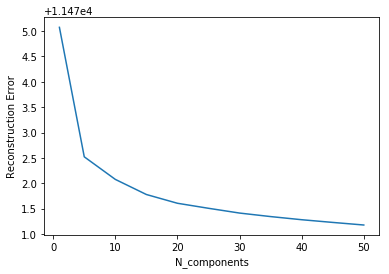

<Figure size 432x288 with 0 Axes>

In [37]:
plt.plot(K, Loss)
plt.xlabel("N_components")
plt.ylabel("Reconstruction Error")
plt.show()
plt.savefig("9_reconstructed_error.png")